In [128]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats

from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [123]:
# loading the train labels

labels_df = pd.read_csv('train_labels.csv')

labels_df['session'] = labels_df['session_id'].apply(lambda x: int(x.split('_')[0]))
labels_df['question'] = labels_df['session_id'].apply(lambda x: int(x.split('q')[1]))

labels_df = (
    labels_df
    .sort_values(by=['session', 'question'], ascending=[True, True])
    .reindex(columns=['session_id', 'session', 'question', 'correct'])
    .reset_index(drop=True)
    .drop(columns='session_id')
)

labels_df.head()

,session,question,correct
0,20090312431273200,1,1
1,20090312431273200,2,1
2,20090312431273200,3,1
3,20090312431273200,4,1
4,20090312431273200,5,1


In [124]:
# excluding cols to save memory
exclude_cols = ['index', 'fullscreen', 'hq', 'music', 'text']

# borrowing the dtypes dictionary from a featured notebook
dtypes = {
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text': 'category',
    'fqid': 'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen': bool,
    'hq':bool,
    'music': bool,
    'level_group':'category'
}

df = pd.read_csv('train.csv', usecols=lambda x: x not in exclude_cols, dtype=dtypes)

df = (
    df
    .sort_values(by=['session_id', 'level', 'elapsed_time'], ascending=[True, True, True])
    .reset_index(drop=True)
)

# extracting date and time data from the session_id
df['year'] = df['session_id'].apply(lambda x: int(str(x)[:2]))
df['month'] = df['session_id'].apply(lambda x: int(str(x)[2:4]))
df['day'] = df['session_id'].apply(lambda x: int(str(x)[4:6]))
df['hour'] = df['session_id'].apply(lambda x: int(str(x)[6:8]))

# creating a weekend indicator because weekends are different
df['weekend'] = np.where(df['day'].isin([6,0]), 1, 0)

# simple distance calculation
df['room_distance'] = np.sqrt(df['room_coor_x'] ** 2 + df['room_coor_y'] ** 2)
df['screen_distance'] = np.sqrt(df['screen_coor_x'] ** 2 + df['screen_coor_y'] ** 2)

In [ ]:
#i like this feature and the code to produce it, but it may not be useful
#out for now
# def get_last_4(x):
#     return x.iloc[-4:]


# # get last 4 fqid
# fqid_df = df.groupby(['session_id', 'level_group'])['fqid'].apply(get_last_4).reset_index()
# fqid_df['entry_number'] = fqid_df.groupby(['session_id', 'level_group']).cumcount() + 1

# final_fqid = (
#     fqid_df
#     .pivot(index=['session_id', 'level_group'],
#            columns='entry_number',
#            values='fqid')
#     .rename(columns={1:'fqid_1back', 2:'fqid_2back', 3:'fqid_3back', 4:'fqid_4back'})
# )

# final_fqid

In [96]:
def get_data_for_level(level_group=None, labels_df=labels_df):
    "gets group-level data to train models for each question"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = df[df['level_group'] == level_group].copy()    
    
    
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(x.min()))
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(abs(x.min())))
    )
    
    # room coord stats
    screen_coor_stats = df_.groupby('session_id').agg(screen_coor_x_mean=('screen_coor_x', 'mean'),
                                                      screen_coor_x_std=('screen_coor_x', 'std'),
                                                      screen_coor_y_mean=('screen_coor_y', 'mean'),
                                                      screen_coor_y_std=('screen_coor_y', 'std'),
                                                      manhat_screen_mean=('screen_distance', 'mean'),
                                                      manhat_screen_std=('screen_distance', 'std'))
    
    # time delta stats    
    time_delta_stats = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # hover duration stats
    hover_duration_stats = df_.groupby('session_id').agg(hover_duration_mean=('hover_duration', 'mean'),
                                                        hover_duration_std=('hover_duration', 'std'),
                                                        hover_duration_max=('hover_duration', 'max'))
                                                        
                                            
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time=('time_delta_til_next', 'sum'))
        .unstack()
    )   
    
    
    # unique fqids 
    nunique_fqid = df_.groupby('session_id')['fqid'].nunique()
    
    # unique rooms
    nunique_rooms = df_.groupby('session_id')['room_fqid'].nunique()
    time_in_rooms = (
        df_
        .groupby(['session_id', 'room_fqid'])['time_delta_til_next']
        .sum()
        .unstack()
    )
    
    # unique text
    nunique_text = df_.groupby('session_id')['text_fqid'].nunique()
    
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # page counts
    page_counts = df_.groupby('session_id')['page'].value_counts().unstack().fillna(0)
    page_counts.columns = [f'page_{x}' for x in page_counts.columns]
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count().rename('total_events')
    
    # getting labels
    session_labels = (
        labels_df
        .loc[labels_df.question.isin(level_dict[level_group])]
        .pivot(columns='question', values='correct', index='session')
    )
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_fqid, event_counts,
                   session_lengths, session_events, time_delta_stats,
                   hover_duration_stats, page_counts, nunique_rooms, time_in_rooms,
                   nunique_text, screen_coor_stats], axis=1)
    )
    
    bad_cols = ['year', 'checkpoint', 'weekend', 'fqid', 'notification_click',  
                'cutscene_click', 'observation_click']
    
    feature_cols = [col for col in df_features.columns if col not in bad_cols]
    
    
    return df_features, feature_cols

In [97]:
# creating these df to speed up training
# originally i had it setup so it could be replicated
# (including model training) in a kaggle notebook with a 
# very limited memory, but i need to improve the model stuff
# first - this speeds it up
group1_df, group1_features = get_data_for_level('0-4')
group2_df, group2_features = get_data_for_level('5-12')
group3_df, group3_features = get_data_for_level('13-22')

In [98]:
# creating a df of the best params 

best_params_df = pd.DataFrame()

for question in range(1, 19):
    
    if question in [1, 2, 3]:
        df_ = group1_df
        feature_cols = group1_features

    elif question in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        df_ = group2_df
        feature_cols = group2_features
    else:
        df_ = group3_df
        feature_cols = group3_features
    
    model = XGBClassifier()
    cv_method = GroupKFold(n_splits=5)
    
    grid_params_ = {
        'n_estimators' : [25, 100],
        'max_depth' : [3, 6, 8],
        'min_child_weight' : [5, 10]
    }
    
    X = df_[feature_cols]
    X_groups = df_.index
    y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[X_groups]['correct']
    
    
    gridsearch = GridSearchCV(model,
                              param_grid=grid_params_,
                              cv=cv_method.split(X, y, groups=X_groups),
                              scoring='f1_macro')    
    gridsearch.fit(X, y)
    
    best_depth = gridsearch.best_params_['max_depth']
    best_weight = gridsearch.best_params_['min_child_weight']
    best_score = gridsearch.best_score_
    best_estimators = gridsearch.best_params_['n_estimators']
    
    param_score_df_ = pd.DataFrame({
        'question' : question,
        'estimators' : best_estimators,
        'best_depth' : best_depth,
        'best_weight' : best_weight,
        'best_score' : best_score},
        index=[0]
    )
    
    best_params_df = pd.concat([best_params_df, param_score_df_])
    print(best_score, gridsearch.best_params_)

0.6168851195811931 {'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100}
0.529798676966433 {'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100}
0.5075908850222242 {'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100}
0.6122872895944642 {'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100}
0.6210646639692208 {'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 25}
0.5740891435098907 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100}
0.5466529859323008 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100}
0.525783515799181 {'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100}
0.5670860703059268 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100}
0.6160279167101008 {'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 25}
0.5543554084066614 {'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100}
0.5038679484052873 {'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100}
0.5639258410358885 {'max_depth': 6,

In [125]:
# getting the best params from the gridsearch
# param_dict = best_params_df.set_index('question')[['best_depth', 'best_weight']].to_dict()

# creating a groupkfold object
gkf = GroupKFold(n_splits=7)

# creating a dataframe to get the out of fold predictions
oof = pd.DataFrame(
    data=np.zeros((len(df['session_id'].unique()), 18)),
    index=df['session_id'].unique(),
)

# dictionary to keep the trained models
models = {}

for question in range(1, 19):
    if question in [1, 2, 3]:
        df_ = group1_df.copy()
        feature_cols = group1_features
    elif question in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        df_ = group2_df.copy()
        feature_cols = group2_features
    else:
        df_ = group3_df.copy()
        feature_cols = group3_features
        
    for i, (train_index, val_index) in enumerate(gkf.split(X=df_, groups=df_.index)):
        print(f"Fold {i + 1} => ", end="")
        
        # defining the params for the model, including the best params from gridsearch
        xgb_params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "learning_rate": 0.05,
            "n_estimators": 1000,
            "early_stopping_rounds": 50
        }

        # train data
        train_x = df_.iloc[train_index].copy()
        train_sessions = train_x.index.values.tolist()
        train_x = train_x[feature_cols].copy()
        train_y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[train_sessions]['correct']

        # validate data
        val_x = df_.iloc[val_index].copy()
        val_sessions = val_x.index.values.tolist()
        val_x = val_x[feature_cols]
        val_y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[val_sessions]['correct']

        # training the model using the params above
        clf = XGBClassifier(**xgb_params)       

        clf.fit(
            train_x,
            train_y,
            eval_set=[(val_x, val_y)],
            verbose=0,
        )

        print(f"{question}({clf.best_ntree_limit}), ", end="")
        
        # putting the out of fold predictions into the dataframe
        oof.loc[val_sessions, question - 1] = clf.predict_proba(
            val_x[feature_cols])[:, 1]
        
        # adding the models to the model dictionary
        models[f'question_{question}_fold_{i}'] = clf

Fold 1 => 1(106), Fold 2 => 1(100), Fold 3 => 1(134), Fold 4 => 1(130), Fold 1 => 2(103), Fold 2 => 2(96), Fold 3 => 2(131), Fold 4 => 2(151), Fold 1 => 3(100), Fold 2 => 3(132), Fold 3 => 3(107), Fold 4 => 3(90), Fold 1 => 4(74), Fold 2 => 4(91), Fold 3 => 4(86), Fold 4 => 4(86), Fold 1 => 5(66), Fold 2 => 5(106), Fold 3 => 5(53), Fold 4 => 5(87), Fold 1 => 6(85), Fold 2 => 6(80), Fold 3 => 6(101), Fold 4 => 6(106), Fold 1 => 7(78), Fold 2 => 7(74), Fold 3 => 7(80), Fold 4 => 7(90), Fold 1 => 8(35), Fold 2 => 8(96), Fold 3 => 8(89), Fold 4 => 8(151), Fold 1 => 9(93), Fold 2 => 9(86), Fold 3 => 9(93), Fold 4 => 9(72), Fold 1 => 10(66), Fold 2 => 10(120), Fold 3 => 10(56), Fold 4 => 10(73), Fold 1 => 11(79), Fold 2 => 11(55), Fold 3 => 11(42), Fold 4 => 11(62), Fold 1 => 12(76), Fold 2 => 12(71), Fold 3 => 12(83), Fold 4 => 12(82), Fold 1 => 13(78), Fold 2 => 13(111), Fold 3 => 13(141), Fold 4 => 13(70), Fold 1 => 14(78), Fold 2 => 14(110), Fold 3 => 14(86), Fold 4 => 14(65), Fold 1 => 

In [ ]:
feature_importances = pd.DataFrame()

for model in models.keys():
    model_ = models[model]
    question = int(model.split('_')[1])
    fold = int(model.split('_')[-1])
    df_ = pd.DataFrame({a:b for a, b in zip(feature_cols, model_.feature_importances_)}, index=[0])
    df_.insert(0, 'question', question)
    df_.insert(1, 'fold', fold)
    feature_importances = pd.concat([feature_importances, df_])

feature_importances.groupby('question').max()

In [126]:
# finding the matching targets
target_df = (
    labels_df[labels_df['session'].isin(oof.index)]
    .pivot(index='session', columns='question', values='correct')
)

# lists for scores and thresholds
scores = []
thresholds = []

best_score = 0
best_threshold = 0

# iterate over all the possible thresholds
for threshold in np.arange(0.4, 0.81, 0.01):    
    
    # get the preds
    pred_df = (oof > threshold).astype(int)
    
    # using numpy concatenate to clean this up
    m = f1_score(np.concatenate(target_df.values),
                 np.concatenate(pred_df.values.round(0)),
                 average='macro')
    
    # appending to the dataframe
    scores.append(m)
    thresholds.append(threshold)
    
    # only change em if they exceed highest value so far
    if m > best_score:
        best_score = m
        best_threshold = threshold

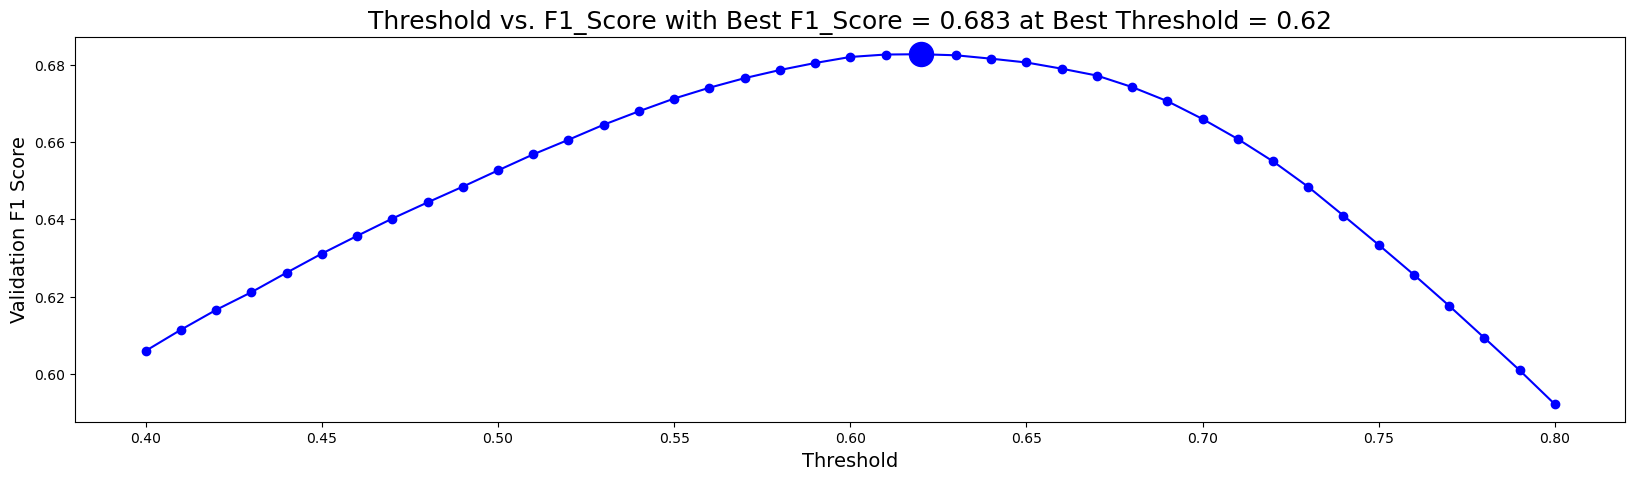

In [127]:
# stealing a plot from another person, but it looks nice

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, "-o", color="blue")
plt.scatter([best_threshold], [best_score], color="blue", s=300, alpha=1)
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score", size=14)
plt.title(
    f"Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}",
    size=18,
)
plt.show()

In [ ]:
def prep_data(df=None):
    "how to prep the data for the kaggle notebook"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = df.copy()
    
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(x.min()))
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(abs(x.min())))
    )
    
    # time delta means    
    time_delta_mean = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time=('time_delta_til_next', 'sum'))
        .unstack()
    )   
    
    # unique text ids
    nunique_text_ids = df_.groupby('session_id')['text_fqid'].nunique()
    
    # unique fqids 
    nunique_fqid = df_.groupby('session_id')['fqid'].nunique()
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count()
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_text_ids, nunique_fqid, event_counts, session_lengths, session_events, time_delta_mean], axis=1)
        .drop(columns='session_id')
        .reset_index()
    )
    
    df_features['year'] = df_features['session_id'].apply(lambda x: int(str(x)[:2]))
    df_features['month'] = df_features['session_id'].apply(lambda x: int(str(x)[2:4]))
    df_features['day'] = df_features['session_id'].apply(lambda x: int(str(x)[4:6]))
    df_features['hour'] = df_features['session_id'].apply(lambda x: int(str(x)[6:8]))

    # # creating a weekend indicator because weekends are different
    df_features['weekend'] = np.where(df_features['day'].isin([6,0]), 1, 0)
    
    return df_features

In [ ]:
# saving models
for key in models.keys():
    
    model_ = models[key]
    
    with open(f'model_{key}.pickle', 'wb') as file:
        pickle.dump(model_, file, protocol=4)

In [ ]:
# saving features
with open('feature_cols_may17.pickle', 'wb') as file:
    pickle.dump(feature_cols, file, protocol=4)

In [ ]:
# this cell iterates over the test data 
test_df = pd.read_csv('test.csv')

# defining the questions for each group
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for _, tf in test_df.groupby(['session_id', 'level_group']):
    
    # get the level group (to get the data for the model)
    level_group = tf['level_group'].values[0]
    
    # create feature df
    df_ = prep_data(tf)
    
    # figure out if feature columns are missing - important for submission
    missing_columns = list(set(feature_cols) - set(df_.columns))
    
    # create a dataframe with the missing columns filled with 0s (for now)
    missing_df = pd.DataFrame(0, columns=missing_columns, index=df_.index)
    
    # combine the original df and the missing df
    df_ = pd.concat([df_, missing_df], axis=1)
    
    # get the questions to iterate over
    a, b = limits[level_group]  
    
    for question in range(a, b):
        # getting model and threshold for the question
        model_ = models[question][0]
        threshold = models[question][1]
        
        raw_pred_proba = model_.predict_proba(df_[feature_cols])[0, 1]
        final_pred = (raw_pred_proba > threshold).astype(int)
    
    print(final_pred)